# Line Detection V2
1. เวอร์ชั่นนี้จะเป็นการตรวจจับบรรทัดแบบทั้งแถวเลย
2. เรียงตัวอักษรจากซ้ายไปขวา

## Histogram Projection
ใช้ Histogram Projection เพื่อแยกบรรทัดในแนวนอน:

Lines detected: [(32, 51), (91, 92), (97, 138), (156, 182), (201, 227), (249, 274), (295, 321), (325, 325), (339, 340), (342, 368), (370, 372), (390, 418), (438, 464), (467, 710), (731, 2085), (2095, 2197), (2215, 2240), (2257, 2281)]


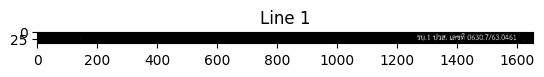

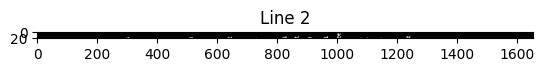

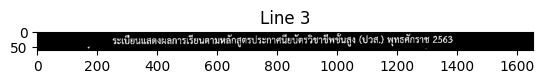

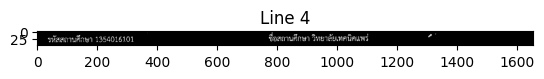

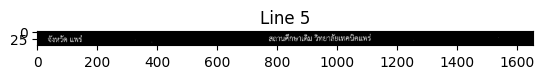

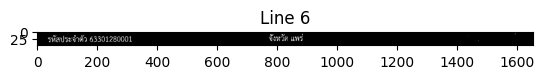

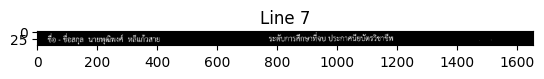

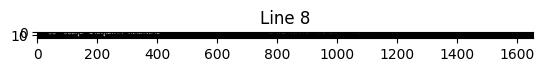

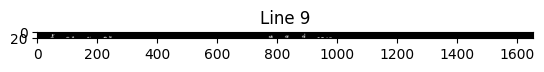

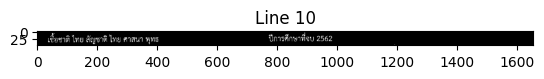

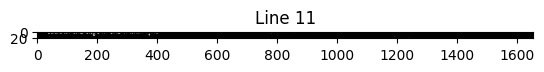

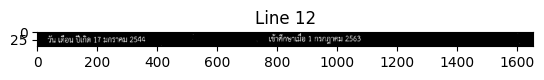

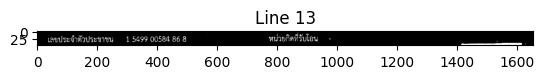

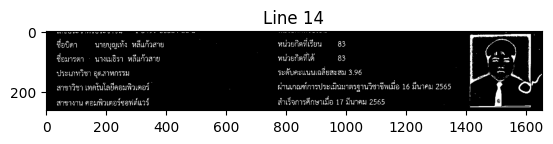

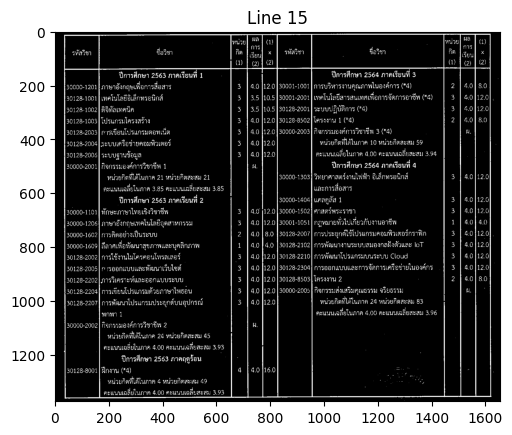

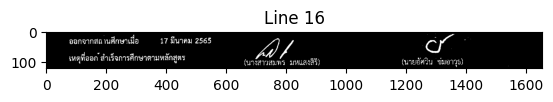

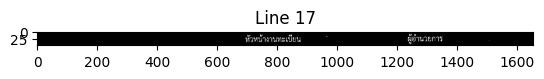

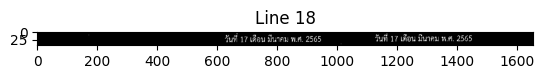

Saved lines to ..\data\output_images\output_lines


'\n# เพิ่มเส้นกรอบรอบข้อความแต่ละบรรทัด\nfor start, end in lines:\n    cv2.rectangle(image, (0, start), (image.shape[1], end), (0, 255, 0), 2)\ncv2.imshow("Detected Lines", image)\ncv2.imshow("Binary Image", binary_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\n# การแยกข้อความแต่ละบรรทัดออกเป็นภาพย่อย\nline_images = [binary_image[start:end, :] for start, end in lines]\nfor idx, line_img in enumerate(line_images):\n    cv2.imshow(f"Line {idx + 1}", line_img)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n'

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

# โหลดภาพ
#image = cv2.imread("../data/test_images/line_detection/test_a_to_z_3.jpg")
#image = cv2.imread("../data/test_images/line_detection/testAtoZ_1.jpg")
#image = cv2.imread("../data/test_images/line_detection/0to9_2.jpg")
image = cv2.imread("../data/test_images/transcript/aun_20240817_0001.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

'''
# แปลงเป็น Binary
_, binary_image = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # Threshold ขาวดำ
'''

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(binary_image, axis=1)  # รวมพิกเซลในแนวนอน

threshold_value = 2000  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
line_indices = np.where(horizontal_projection > threshold_value)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)

# แยกบรรทัดและเพิ่ม Padding
line_images = []
padding = 10  # ระบุ Padding

for start, end in lines:
    padded_start = max(0, start - padding)
    padded_end = min(binary_image.shape[0], end + padding)
    line_img = binary_image[padded_start:padded_end, :]
    line_images.append(line_img)

for idx, line_img in enumerate(line_images):
    file_path = output_folder / f"line_{idx + 1}.png"
    cv2.imwrite(str(file_path), line_img)
    plt.figure()
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line {idx + 1}")
    plt.show()
print(f"Saved lines to {output_folder}")

'''
# เพิ่มเส้นกรอบรอบข้อความแต่ละบรรทัด
for start, end in lines:
    cv2.rectangle(image, (0, start), (image.shape[1], end), (0, 255, 0), 2)
cv2.imshow("Detected Lines", image)
cv2.imshow("Binary Image", binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# การแยกข้อความแต่ละบรรทัดออกเป็นภาพย่อย
line_images = [binary_image[start:end, :] for start, end in lines]
for idx, line_img in enumerate(line_images):
    cv2.imshow(f"Line {idx + 1}", line_img)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''


## Word/Character Detection
ใช้ cv2.findContours เพื่อตรวจจับตัวอักษรหรือคำในแต่ละบรรทัด:

### แบบใหม่

In [16]:
import cv2
import numpy as np
from pathlib import Path

# สร้างโฟลเดอร์สำหรับเก็บตัวอักษร
output_folder = Path("../data/output_images/output_characters")  # ใช้ Path จาก pathlib
output_folder.mkdir(exist_ok=True)  # สร้างโฟลเดอร์ หากไม่มีอยู่แล้ว

char_images = []

for idx, line_img in enumerate(line_images):
    # หา Contours ในภาพแต่ละบรรทัด
    contours, _ = cv2.findContours(line_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # สร้างสำเนาภาพเพื่อวาดกรอบ
    line_with_boxes = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)
    
    # เรียงตัวอักษรตามตำแหน่งซ้ายไปขวา
    sorted_contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    
    for contour in sorted_contours:
        # คำนวณกรอบสี่เหลี่ยมรอบ Contour
        x, y, w, h = cv2.boundingRect(contour)

        # เพิ่มขนาดกรอบ 10%
        padding_x = int(w * 0.1)  # เพิ่ม 10% ของความกว้าง
        padding_y = int(h * 0.1)  # เพิ่ม 10% ของความสูง

        # ปรับขอบเขตของกรอบ
        x = max(0, x - padding_x)
        y = max(0, y - padding_y)
        w = min(line_img.shape[1] - x, w + 2 * padding_x)
        h = min(line_img.shape[0] - y, h + 2 * padding_y)
        
        # กำหนดเงื่อนไขเพื่อกรอง Noise หรือกล่องเล็กเกินไป
        if 2 < w < 200 and 5 < h < 200:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            # ตัดภาพตัวอักษร
            char_img = line_img[y:y+h, x:x+w]
            char_images.append(char_img)

            # บันทึกตัวอักษร
            file_path = output_folder / f"line_{idx + 1}_char_{len(char_images)}.png"
            cv2.imwrite(str(file_path), char_img)  # แปลง Path เป็น String เพื่อใช้กับ OpenCV

            # วาดกรอบสี่เหลี่ยมในภาพต้นฉบับ
            cv2.rectangle(line_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)

    # บันทึกภาพพร้อมกรอบตัวอักษร (ถ้าต้องการ)
    boxed_line_path = output_folder / f"line_{idx + 1}_boxed.png"
    cv2.imwrite(str(boxed_line_path), line_with_boxes)

    print(f"Line {idx + 1}: Detected {len(sorted_contours)} characters")

# รายงานผลลัพธ์
print(f"Saved {len(char_images)} characters to {output_folder}")


Line 1: Detected 5 characters
Line 2: Detected 6 characters
Saved 10 characters to ..\data\output_images\output_characters


## Predict images

1/1 [==============================] - 0s 74ms/step
Character 0: Predicted Label = 0 (100.00%)
Character 1: Predicted Label = 1 (100.00%)
Character 2: Predicted Label = 2 (100.00%)
Character 3: Predicted Label = 3 (100.00%)
Character 4: Predicted Label = 4 (99.98%)
Character 5: Predicted Label = 5 (100.00%)
Character 6: Predicted Label = 6 (61.06%)
Character 7: Predicted Label = 7 (99.97%)
Character 8: Predicted Label = 8 (98.81%)
Character 9: Predicted Label = 9 (100.00%)


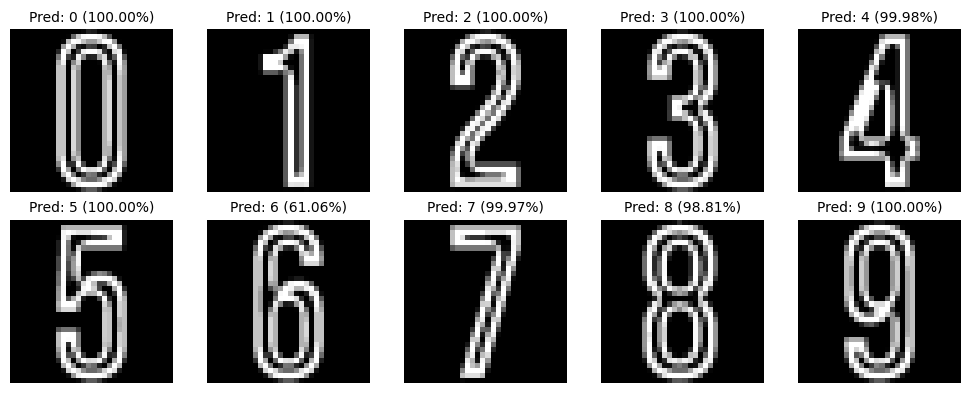

In [17]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

#letter_class = [chr(i) for i in range(ord('a'), ord('z') + 1)]
#letter_class = [chr(i) for i in range(ord('A'), ord('Z') + 1)]
letter_class = [chr(i) for i in range(ord('0'), ord('9') + 1)]

def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# โหลดโมเดลที่ฝึกไว้
model_path = "../models/arabic_numerals_model.h5"
#model_path = "../models/eng_uppercase_model.h5"
#model_path = "../models/eng_lowercase_model.h5"
model = load_model(model_path)

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก char_images
processed_images = []

for char_img in char_images:
    # เพิ่ม Padding และปรับขนาดภาพ
    padded_img = resize_with_aspect_ratio_cv2(char_img, input_size)
    
    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
    normalized_img = padded_img / 255.0
    
    # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
        normalized_img = np.expand_dims(normalized_img, axis=-1)
    
    # เก็บภาพที่ประมวลผลแล้ว
    processed_images.append(normalized_img)

# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

# ทำนายผลลัพธ์
predictions = model.predict(processed_images)


# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ

#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 2, rows * 2))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย
    plt.title(f"Pred: {letter_class[pred_label]} ({confidence:.2%})", fontsize=10)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letter_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()
